# Demo 3 - CS 156 #

## Import Dependencies & Dataset ##

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
from scipy.signal import welch, find_peaks
from sklearn.model_selection import KFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.signal import correlate, find_peaks


In [ ]:

# Load combined dataset
df = pd.read_csv(r"C:\Users\sherv\Desktop\SP25\CS156-main\demo3\new_data")

# All signal columns (from your HARTH dataset)
axes = ["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"]

# Store per-subject feature results
subject_stats = []

# Define time-domain feature computation
def compute_features(signal):
    features = {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "var": np.var(signal),
        "min": np.min(signal),
        "max": np.max(signal),
        "range": np.ptp(signal),
        "median": np.median(signal),
        "iqr": np.percentile(signal, 75) - np.percentile(signal, 25),
        "rms": np.sqrt(np.mean(np.square(signal))),
        "zcr": ((signal[:-1] * signal[1:]) < 0).sum(),
        "skew": skew(signal),
        "kurtosis": kurtosis(signal),
        "energy": np.sum(np.square(signal)),
        "autocorr": np.corrcoef(signal[:-1], signal[1:])[0, 1] if len(signal) > 1 else 0,
        "peak_count": len(find_peaks(signal)[0])
    }
    return features

# Loop through each subject
for subject_id in df["id"].unique():
    row = {"id": subject_id}
    sub_df = df[df["id"] == subject_id]
    
    # Compute Signal Magnitude Area (SMA) for back and thigh
    back_sma = np.mean(np.abs(sub_df["back_x"]) + np.abs(sub_df["back_y"]) + np.abs(sub_df["back_z"]))
    thigh_sma = np.mean(np.abs(sub_df["thigh_x"]) + np.abs(sub_df["thigh_y"]) + np.abs(sub_df["thigh_z"]))
    row["back_sma"] = back_sma
    row["thigh_sma"] = thigh_sma

    # Compute time-domain stats for each axis
    for axis in axes:
        stats = compute_features(sub_df[axis].values)
        for stat_name, value in stats.items():
            row[f"{axis}_{stat_name}"] = value
    
    subject_stats.append(row)

# Convert to DataFrame
subject_stats_df = pd.DataFrame(subject_stats)

# Compute overall stats (averaged over all subjects)
overall_stats = subject_stats_df.mean(numeric_only=True).to_frame(name="Overall_Mean").reset_index()
overall_stats.columns = ["Feature", "Overall_Mean"]

# Show the first few rows of each table in Jupyter Notebook
print("📊 Per-Subject Feature Statistics:")
display(subject_stats_df.head())

print("\n📊 Overall Feature Averages:")
display(overall_stats.head())


# Optionally save them as CSV files for Excel or Google Sheets
subject_stats_df.to_csv("subject_feature_statistics.csv", index=False)
overall_stats.to_csv("overall_feature_averages.csv", index=False)


📊 Per-Subject Feature Statistics:


,id,back_sma,thigh_sma,back_x_mean,back_x_std,back_x_var,back_x_min,back_x_max,back_x_range,back_x_median,...,thigh_z_range,thigh_z_median,thigh_z_iqr,thigh_z_rms,thigh_z_zcr,thigh_z_skew,thigh_z_kurtosis,thigh_z_energy,thigh_z_autocorr,thigh_z_peak_count
0,1,1.326687,1.351477,-0.802201,0.238346,0.056809,-3.542889,0.952109,4.494998,-0.937195,...,10.276452,0.924066,0.857258,0.817983,6976,-0.769780,0.105472,273465.446438,0.968211,140704
1,2,1.379790,1.319124,-0.920351,0.130877,0.017129,-3.066853,0.873471,3.940324,-0.972054,...,9.557515,0.950087,0.737798,0.839556,7325,-1.236050,0.810834,295326.423836,0.947826,125937
2,3,1.391304,1.965097,-0.944405,0.199062,0.039626,-5.238408,0.858455,6.096863,-0.953725,...,11.030254,0.199040,1.085323,0.904405,17650,0.512764,0.237425,126343.502404,0.898845,26482
3,4,1.198823,1.450655,-1.019898,0.186093,0.034631,-2.365137,-0.309204,2.055932,-1.015238,...,9.261038,0.022649,0.427909,0.561947,31277,1.305135,4.907783,111045.222981,0.801730,84205
4,5,1.191779,1.340398,-0.915515,0.242905,0.059003,-3.810360,0.511867,4.322226,-0.987624,...,6.043454,0.978771,0.120163,0.900938,4064,-2.283726,4.597538,310401.142751,0.961669,138153



📊 Overall Feature Averages:


,Feature,Overall_Mean
0,id,11.000000
1,back_sma,1.359009
2,thigh_sma,1.647008
3,back_x_mean,-0.890122
4,back_x_std,0.358888


In [18]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set style
# sns.set(style="whitegrid")
# metrics_to_plot = [
#     "mean", "std", "var", "rms", "zcr", "skew", "kurtosis", "energy", "iqr", "median", "range", "peak_count"
# ]
# axis_prefix = "back_x"  # You can change this to 'thigh_y', etc.

# for metric in metrics_to_plot:
#     col = f"{axis_prefix}_{metric}"
#     if col in subject_stats_df.columns:
#         plt.figure(figsize=(10, 5))
#         sns.barplot(data=subject_stats_df, x="id", y=col, palette="viridis")
#         plt.title(f"{metric.upper()} for '{axis_prefix}' by Subject")
#         plt.xlabel("Subject ID")
#         plt.ylabel(metric)
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()
# for col in ["back_sma", "thigh_sma"]:
#     plt.figure(figsize=(10, 5))
#     sns.barplot(data=subject_stats_df, x="id", y=col, palette="rocket")
#     plt.title(f"{col.upper()} by Subject")
#     plt.xlabel("Subject ID")
#     plt.ylabel("SMA")
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()


In [19]:
def extract_time_features(window):
    return {
        "mean": np.mean(window),
        "std": np.std(window),
        "var": np.var(window),
        "min": np.min(window),
        "max": np.max(window),
        "range": np.ptp(window),
        "median": np.median(window),
        "iqr": np.percentile(window, 75) - np.percentile(window, 25),
        "rms": np.sqrt(np.mean(np.square(window))),
        "zcr": ((window[:-1] * window[1:]) < 0).sum(),
        "skew": skew(window),
        "kurtosis": kurtosis(window),
        "energy": np.sum(np.square(window)),
        "peak_count": len(find_peaks(window)[0])
    }

def extract_freq_features(window, sampling_rate=50):
    fft_vals = fft(window)
    fft_mag = np.abs(fft_vals)[:len(window)//2]
    freqs = np.fft.fftfreq(len(window), d=1/sampling_rate)[:len(window)//2]
    spectral_centroid = np.sum(freqs * fft_mag) / np.sum(fft_mag)
    spectral_entropy = -np.sum((fft_mag/np.sum(fft_mag)) * np.log2(fft_mag/np.sum(fft_mag) + 1e-10))
    spectral_energy = np.sum(fft_mag ** 2)
    dominant_freq = freqs[np.argmax(fft_mag)]
    freq_variance = np.var(fft_mag)
    spectral_flatness = np.exp(np.mean(np.log(fft_mag + 1e-10))) / (np.mean(fft_mag) + 1e-10)
    bandwidth = np.max(freqs) - np.min(freqs)
    psd = welch(window, fs=sampling_rate, nperseg=len(window))[1]
    return {
        "spectral_centroid": spectral_centroid,
        "spectral_entropy": spectral_entropy,
        "spectral_energy": spectral_energy,
        "dominant_freq": dominant_freq,
        "freq_variance": freq_variance,
        "spectral_flatness": spectral_flatness,
        "bandwidth": bandwidth,
        "psd_mean": np.mean(psd)
    }


In [20]:
def extract_features(df, window_size=100, step_size=50):
    X, y, groups = [], [], []

    for subject_id in df["id"].unique():
        sub_df = df[df["id"] == subject_id]
        for i in range(0, len(sub_df) - window_size, step_size):
            window = sub_df.iloc[i:i+window_size]

            # Use the most common label in the window
            label = window["label"].mode()[0]

            combined_features = {}
            for axis in ["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"]:
                td = extract_time_features(window[axis].values)
                fd = extract_freq_features(window[axis].values)
                combined_features.update({f"{axis}_{k}": v for k, v in {**td, **fd}.items()})

            X.append(combined_features)
            y.append(label)
            groups.append(subject_id)

    return pd.DataFrame(X), np.array(y), np.array(groups)


In [ ]:

# Load the full dataset
df = pd.read_csv(r"C:\Users\sherv\Desktop\SP25\CS156-main\demo3\new_data")

# Group by 'id' and sample 50,000 rows per group (with replacement=False to avoid duplicates)
df_sampled = df.groupby("id", group_keys=False).apply(lambda x: x.sample(n=50000, random_state=42))

# Optional: shuffle entire DataFrame afterward
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Now extract features from the sampled data
X, y, groups = extract_features(df_sampled)


In [22]:
print(X.shape)
print(X.dtypes)

(20958, 132)
back_x_mean                  float64
back_x_std                   float64
back_x_var                   float64
back_x_min                   float64
back_x_max                   float64
                              ...   
thigh_z_dominant_freq        float64
thigh_z_freq_variance        float64
thigh_z_spectral_flatness    float64
thigh_z_bandwidth            float64
thigh_z_psd_mean             float64
Length: 132, dtype: object


In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.nlargest(30).index
X_selected = X[top_features]


In [24]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}


In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("\n--- 10-Fold Cross-Validation Results ---")
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for name, model in models.items():
    acc, f1, prec, rec = [], [], [], []
    for train_idx, test_idx in kf.split(X_selected):
        model.fit(X_selected.iloc[train_idx], y[train_idx])
        preds = model.predict(X_selected.iloc[test_idx])
        acc.append(accuracy_score(y[test_idx], preds))
        f1.append(f1_score(y[test_idx], preds, average='weighted', zero_division=0))
        prec.append(precision_score(y[test_idx], preds, average='weighted', zero_division=0))
        rec.append(recall_score(y[test_idx], preds, average='weighted', zero_division=0))
    print(f"{name} - Acc: {np.mean(acc):.4f}, F1: {np.mean(f1):.4f}, Prec: {np.mean(prec):.4f}, Rec: {np.mean(rec):.4f}")



--- 10-Fold Cross-Validation Results ---
Random Forest - Acc: 0.9913, F1: 0.9912, Prec: 0.9914, Rec: 0.9913
KNN - Acc: 0.9646, F1: 0.9645, Prec: 0.9647, Rec: 0.9646
Decision Tree - Acc: 0.9871, F1: 0.9870, Prec: 0.9870, Rec: 0.9871
SVM - Acc: 0.8663, F1: 0.8270, Prec: 0.8016, Rec: 0.8663


In [26]:
print("\n--- Leave-One-Subject-Out Results ---")
logo = LeaveOneGroupOut()
for name, model in models.items():
    acc, f1, prec, rec = [], [], [], []
    for train_idx, test_idx in logo.split(X_selected, y, groups):
        model.fit(X_selected.iloc[train_idx], y[train_idx])
        preds = model.predict(X_selected.iloc[test_idx])
        acc.append(accuracy_score(y[test_idx], preds))
        f1.append(f1_score(y[test_idx], preds, average='weighted', zero_division=0))
        prec.append(precision_score(y[test_idx], preds, average='weighted', zero_division=0))
        rec.append(recall_score(y[test_idx], preds, average='weighted', zero_division=0))
    print(f"{name} - Acc: {np.mean(acc):.4f}, F1: {np.mean(f1):.4f}, Prec: {np.mean(prec):.4f}, Rec: {np.mean(rec):.4f}")



--- Leave-One-Subject-Out Results ---
Random Forest - Acc: 0.8011, F1: 0.8043, Prec: 0.8407, Rec: 0.8011
KNN - Acc: 0.8174, F1: 0.8486, Prec: 0.9375, Rec: 0.8174
Decision Tree - Acc: 0.8132, F1: 0.8237, Prec: 0.9359, Rec: 0.8132
SVM - Acc: 0.7453, F1: 0.7613, Prec: 0.8406, Rec: 0.7453


In [27]:
import pandas as pd

# Store results
results = []

# Run both evaluations in one loop
for eval_name, splitter in [("10-Fold CV", KFold(n_splits=10, shuffle=True, random_state=42)),
                            ("LOSO", LeaveOneGroupOut())]:

    for name, model in models.items():
        acc, f1, prec, rec = [], [], [], []
        for train_idx, test_idx in splitter.split(X_selected, y, groups if eval_name == "LOSO" else None):
            model.fit(X_selected.iloc[train_idx], y[train_idx])
            preds = model.predict(X_selected.iloc[test_idx])
            acc.append(accuracy_score(y[test_idx], preds))
            f1.append(f1_score(y[test_idx], preds, average='weighted', zero_division=0))
            prec.append(precision_score(y[test_idx], preds, average='weighted', zero_division=0))
            rec.append(recall_score(y[test_idx], preds, average='weighted', zero_division=0))

        results.append({
            "Model": name,
            "Evaluation": eval_name,
            "Accuracy": np.mean(acc),
            "F1 Score": np.mean(f1),
            "Precision": np.mean(prec),
            "Recall": np.mean(rec)
        })

# Create DataFrame
results_df = pd.DataFrame(results)
print(results_df)


           Model  Evaluation  Accuracy  F1 Score  Precision    Recall
0  Random Forest  10-Fold CV  0.991125  0.990996   0.991279  0.991125
1            KNN  10-Fold CV  0.964644  0.964494   0.964664  0.964644
2  Decision Tree  10-Fold CV  0.986736  0.986698   0.986716  0.986736
3            SVM  10-Fold CV  0.866304  0.827003   0.801638  0.866304
4  Random Forest        LOSO  0.796164  0.796138   0.840683  0.796164
5            KNN        LOSO  0.817397  0.848573   0.937484  0.817397
6  Decision Tree        LOSO  0.810764  0.821261   0.935885  0.810764
7            SVM        LOSO  0.745252  0.761341   0.840604  0.745252


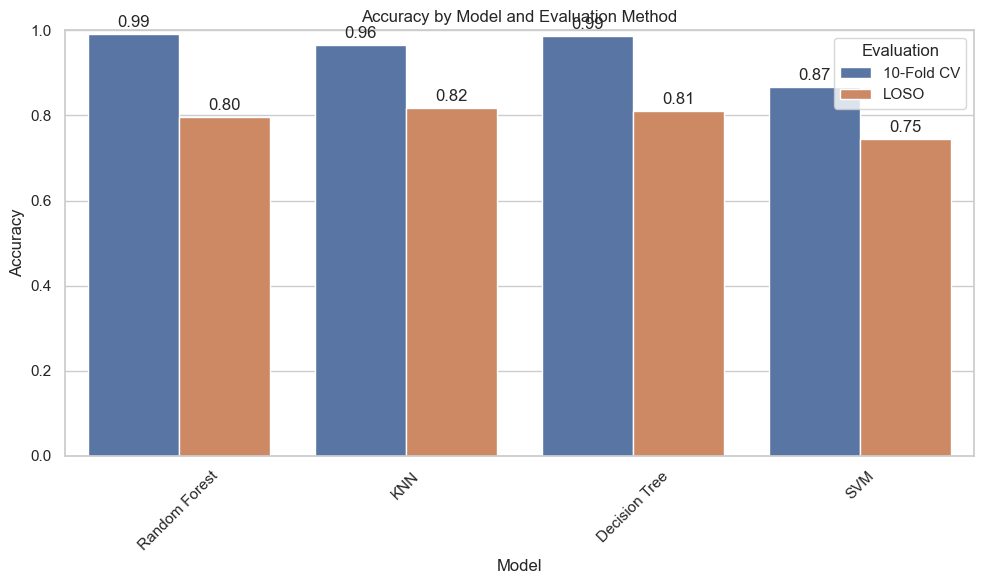

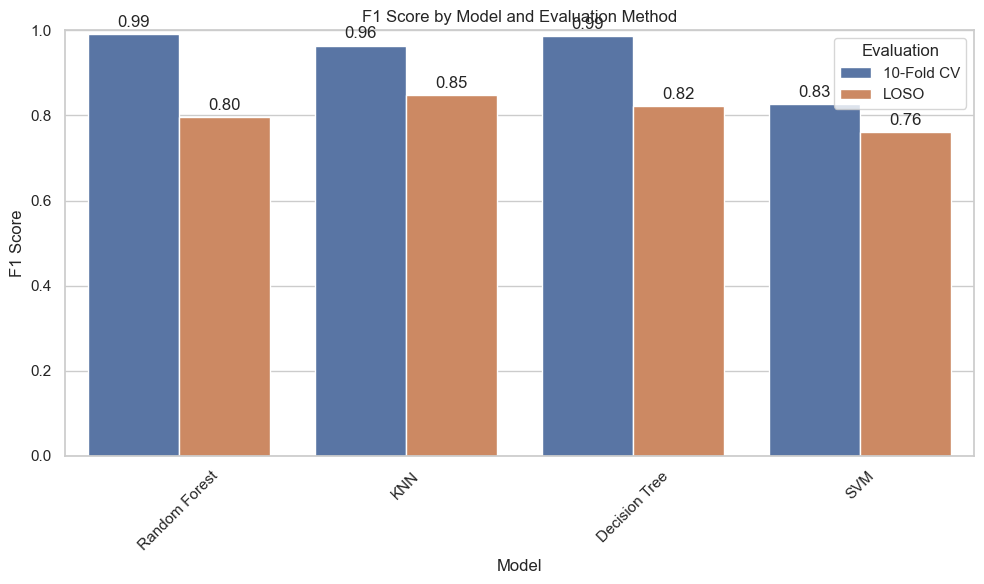

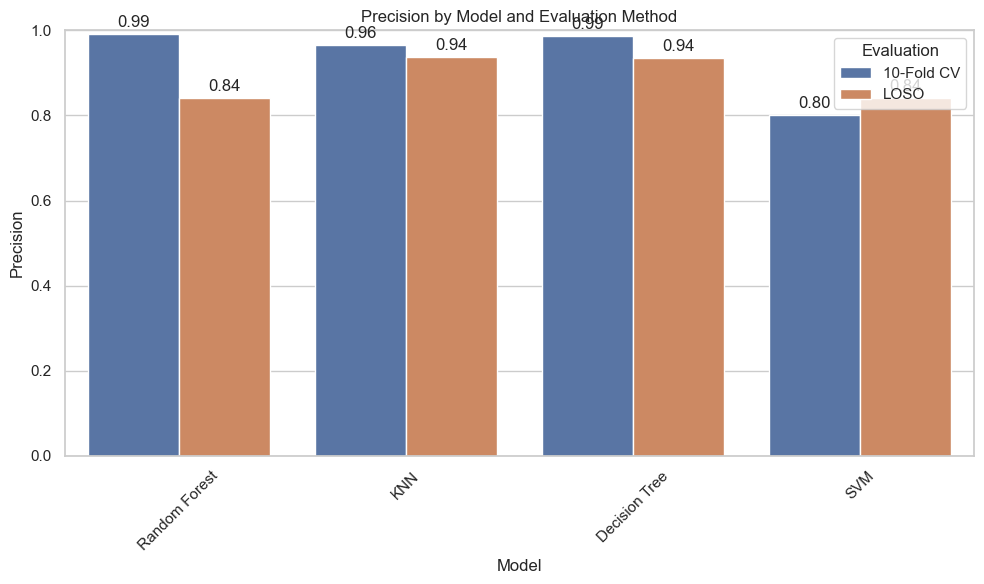

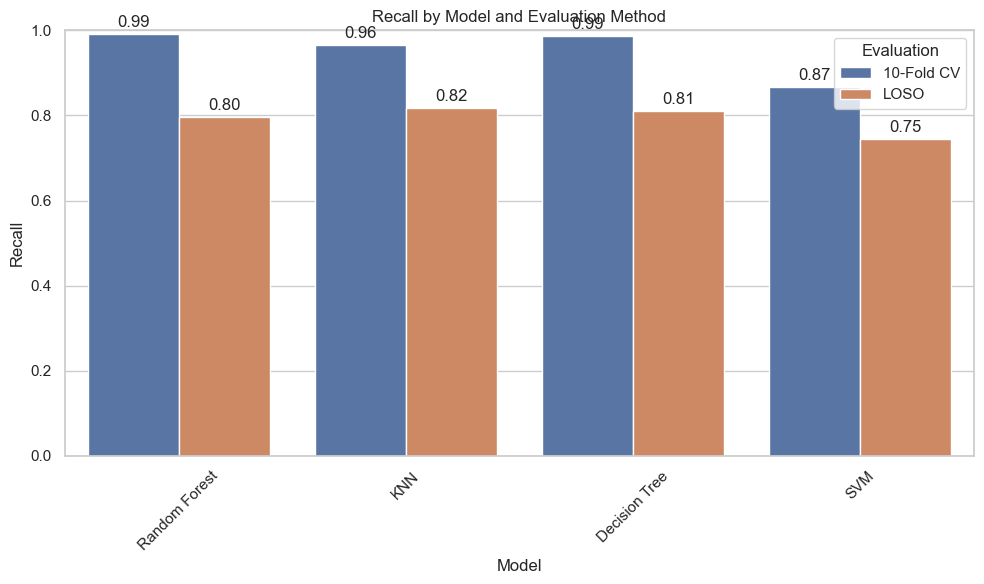

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["Accuracy", "F1 Score", "Precision", "Recall"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=results_df, x="Model", y=metric, hue="Evaluation")
    plt.title(f"{metric} by Model and Evaluation Method")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title="Evaluation")

    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    plt.tight_layout()
    plt.show()


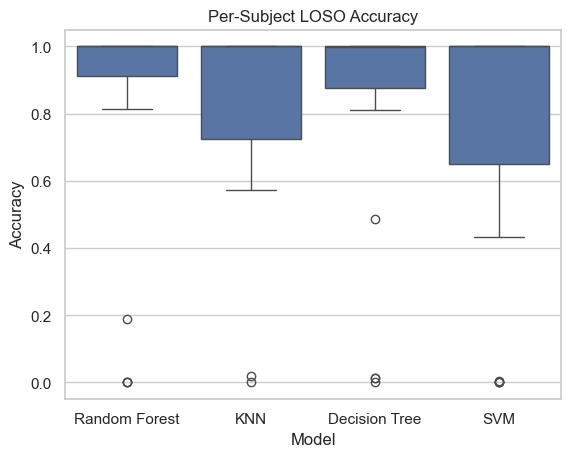

In [29]:
subject_results = []

logo = LeaveOneGroupOut()
for name, model in models.items():
    for train_idx, test_idx in logo.split(X_selected, y, groups):
        model.fit(X_selected.iloc[train_idx], y[train_idx])
        preds = model.predict(X_selected.iloc[test_idx])
        acc = accuracy_score(y[test_idx], preds)
        subject_id = groups[test_idx][0]
        subject_results.append({"Model": name, "Subject": subject_id, "Accuracy": acc})

subject_df = pd.DataFrame(subject_results)
sns.boxplot(data=subject_df, x="Model", y="Accuracy")
plt.title("Per-Subject LOSO Accuracy")
plt.show()


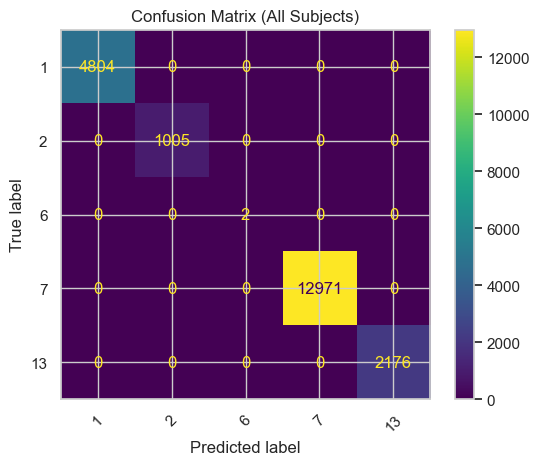

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = RandomForestClassifier(n_estimators=100)
model.fit(X_selected, y)
preds = model.predict(X_selected)

ConfusionMatrixDisplay.from_predictions(y, preds, xticks_rotation=45)
plt.title("Confusion Matrix (All Subjects)")
plt.show()


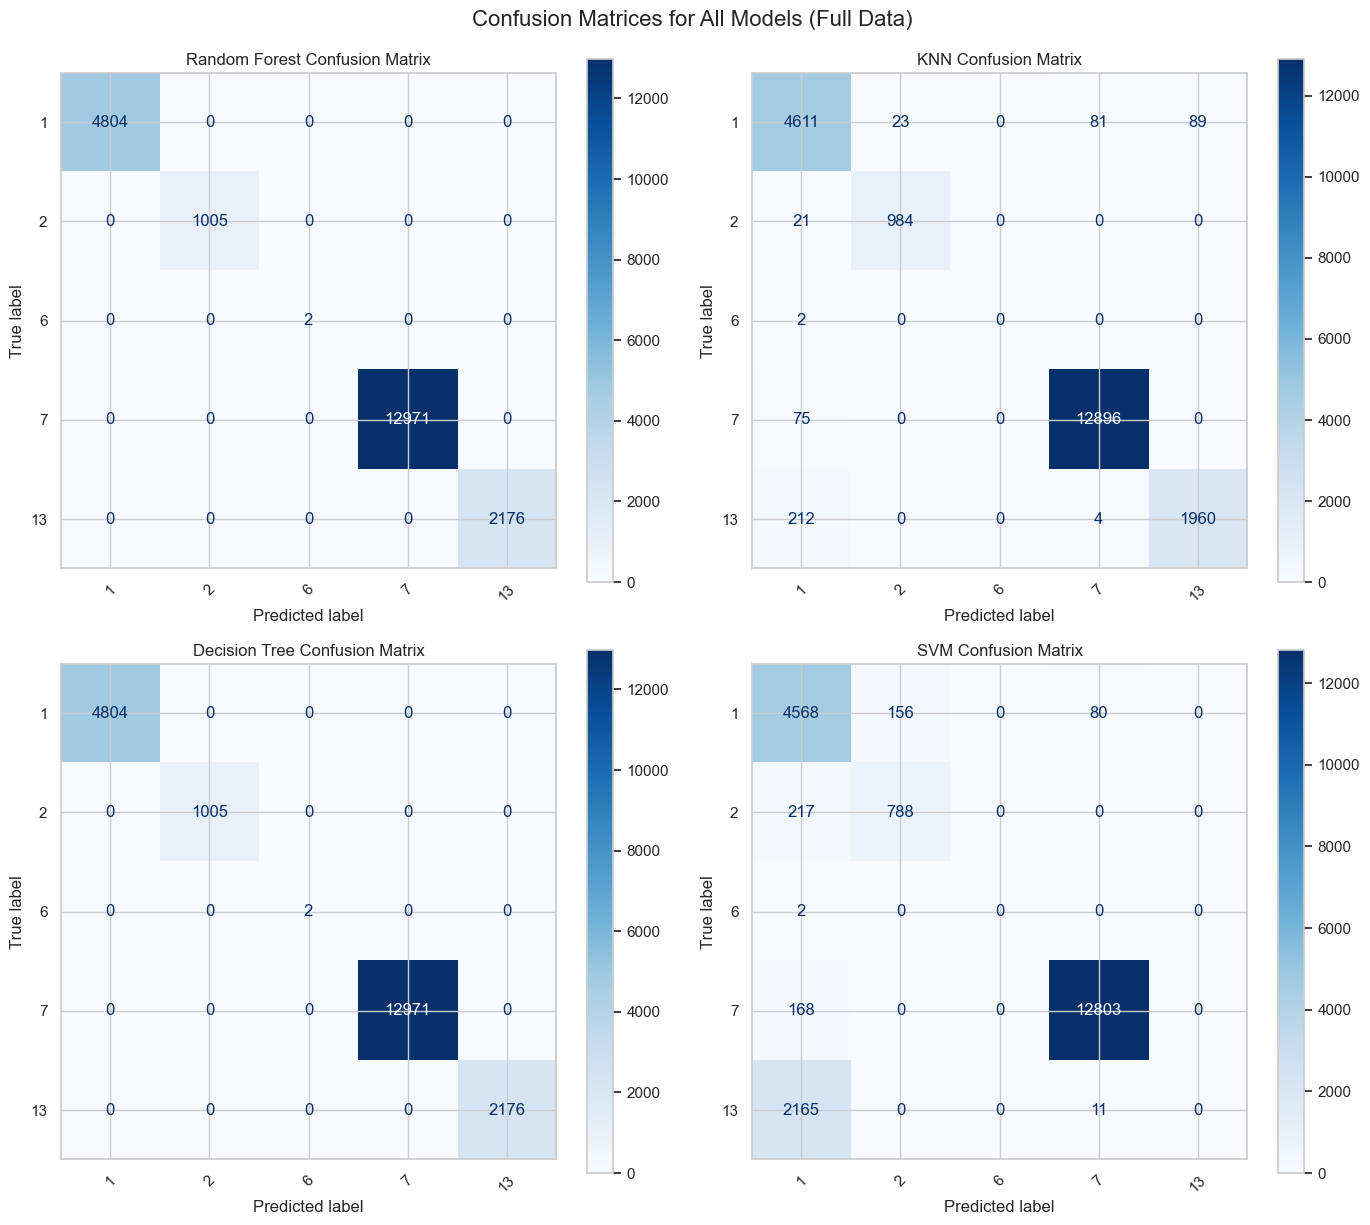

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_selected, y)
    preds = model.predict(X_selected)

    disp = ConfusionMatrixDisplay.from_predictions(y, preds, ax=ax, cmap='Blues', xticks_rotation=45)
    ax.set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models (Full Data)", fontsize=16, y=1.02)
plt.show()


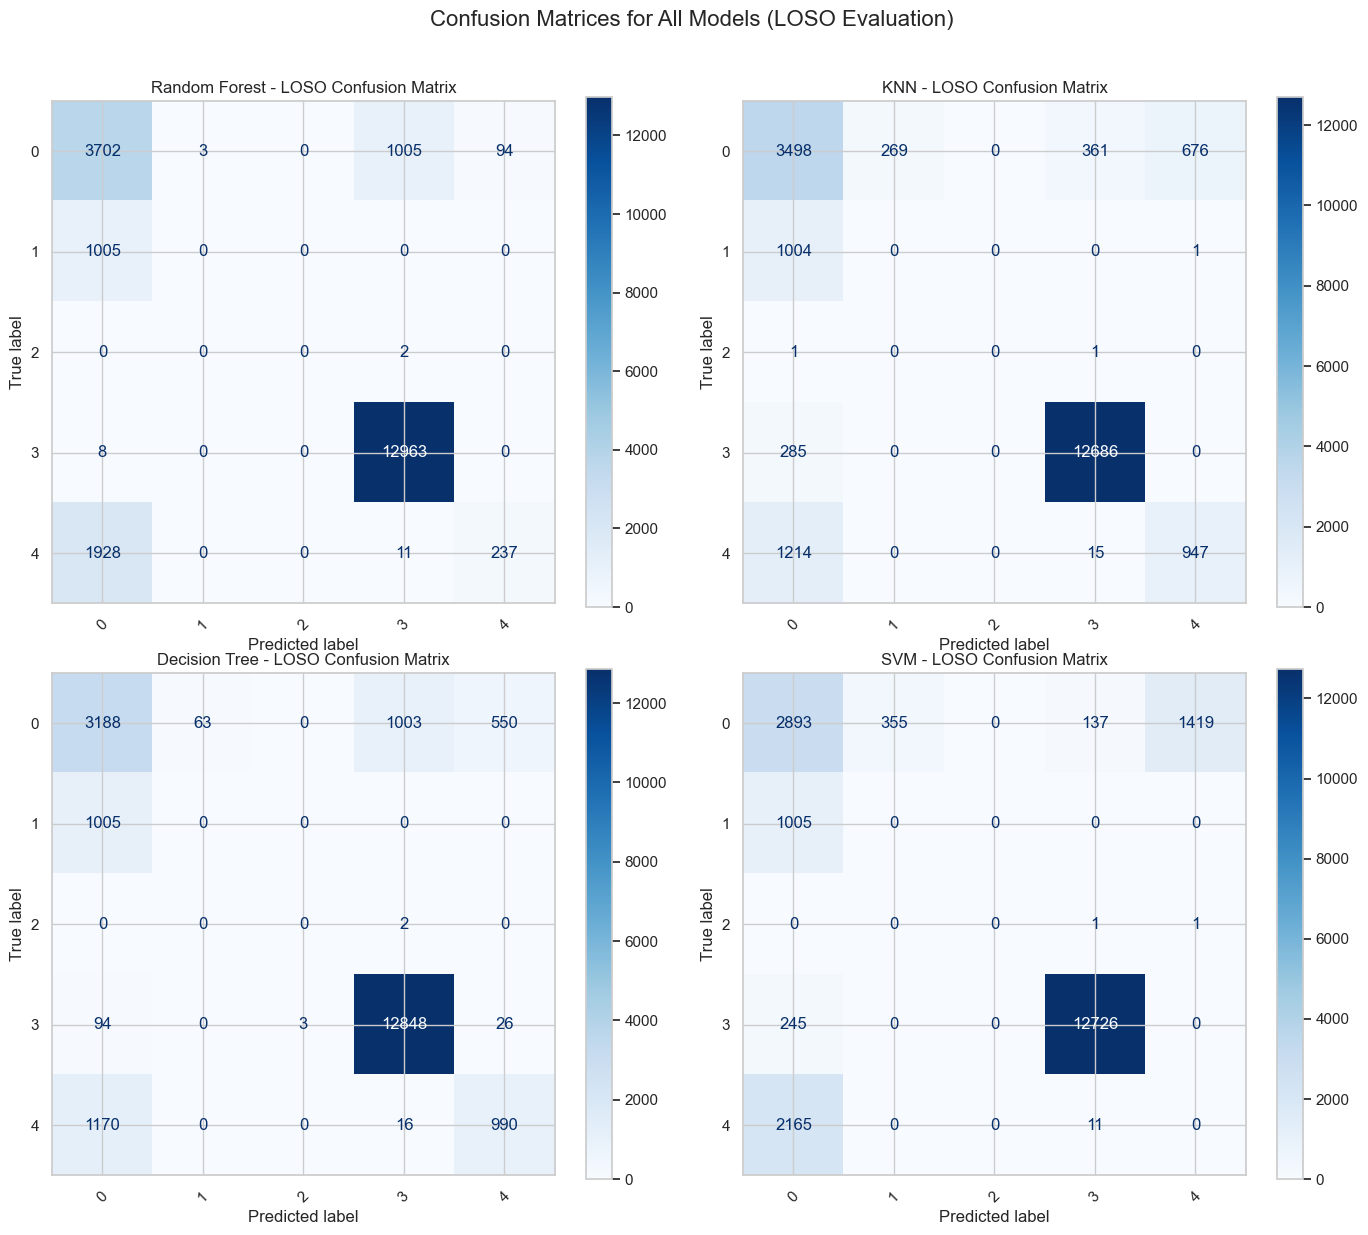

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

logo = LeaveOneGroupOut()

for ax, (name, model) in zip(axes, models.items()):
    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in logo.split(X_selected, y, groups):
        model.fit(X_selected.iloc[train_idx], y[train_idx])
        preds = model.predict(X_selected.iloc[test_idx])
        y_true_all.extend(y[test_idx])
        y_pred_all.extend(preds)

    cm = confusion_matrix(y_true_all, y_pred_all)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    ax.set_title(f"{name} - LOSO Confusion Matrix")

plt.suptitle("Confusion Matrices for All Models (LOSO Evaluation)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


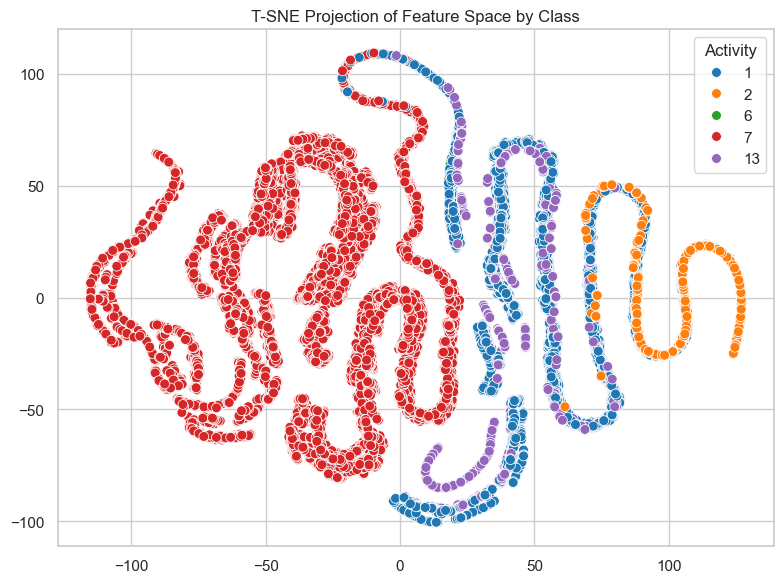

In [33]:
from sklearn.manifold import TSNE
import seaborn as sns

X_vis = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_selected)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y, palette='tab10', s=50)
plt.title("T-SNE Projection of Feature Space by Class")
plt.legend(title='Activity')
plt.tight_layout()
plt.show()
